<a href="https://colab.research.google.com/github/YongMOK/MAP361HashTables/blob/main/APM_51053_EP_Lab_1_with_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1 - Foundations of Machine Learning - APM_51053_EP

The goal of the labs will be to apply (and sometimes extend) what has been seen during the lectures on medium/small datasets. We will use `Python` and rely a lot on a ML stack consisting of `scikit learn`, `polars` and `seaborn`. To avoid configuration issue, I suggest that you use Colab, but feel free to install this ML stack to your own computer. Last but not least, if you use Colab, you will have access to an advanced AI completion engine. You can (should?) use it during the labs, but be aware that the suggested code may not be correct!


Let's start by updating the libraries of Colab to the some recent ones to have a better polar support.



In [ ]:
!pip install -U "seaborn>=0.13.2"
!pip install -U "polars>=1.6.0"
!pip install -U "scikit-learn>=1.5.1"

For most labs, we will use a Credit Risk dataset that has been prepared by IBM. You can download it with the following code:

In [ ]:
!rm german_credit_data_biased_training.csv
!wget https://raw.githubusercontent.com/IBM/monitor-wml-model-with-watson-openscale/master/data/german_credit_data_biased_training.csv

--2024-09-06 13:01:00--  https://raw.githubusercontent.com/IBM/monitor-wml-model-with-watson-openscale/master/data/german_credit_data_biased_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689622 (673K) [text/plain]
Saving to: ‘german_credit_data_biased_training.csv’

german_credit_data_ 100%[===================>] 673.46K  --.-KB/s    in 0.04s   

2024-09-06 13:01:00 (18.4 MB/s) - ‘german_credit_data_biased_training.csv’ saved [689622/689622]



The goals of this lab are:
- to read the data and look at it,
- to build and train a machine learning pipeline
- to assess its quality with cross-validation

## A first look at the dataset

To read the CSV files with `polars`, we need first import the library

In [ ]:
import polars as pl

and then use the `pl.read_csv` function.

In [ ]:
german_credit = pl.read_csv("german_credit_data_biased_training.csv")

The `head` method give us a glimpse on the content of the table: a mix of categorical variables `str` and numerical ones `i64`.

In [ ]:
german_credit.head()

CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,CurrentResidenceDuration,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
str,i64,str,str,i64,str,str,i64,str,str,i64,str,i64,str,str,i64,str,i64,str,str,str
"""0_to_200""",31,"""credits_paid_to_date""","""other""",1889,"""100_to_500""","""less_1""",3,"""female""","""none""",3,"""savings_insurance""",32,"""none""","""own""",1,"""skilled""",1,"""none""","""yes""","""No Risk"""
"""less_0""",18,"""credits_paid_to_date""","""car_new""",462,"""less_100""","""1_to_4""",2,"""female""","""none""",2,"""savings_insurance""",37,"""stores""","""own""",2,"""skilled""",1,"""none""","""yes""","""No Risk"""
"""less_0""",15,"""prior_payments_delayed""","""furniture""",250,"""less_100""","""1_to_4""",2,"""male""","""none""",3,"""real_estate""",28,"""none""","""own""",2,"""skilled""",1,"""yes""","""no""","""No Risk"""
"""0_to_200""",28,"""credits_paid_to_date""","""retraining""",3693,"""less_100""","""greater_7""",3,"""male""","""none""",2,"""savings_insurance""",32,"""none""","""own""",1,"""skilled""",1,"""none""","""yes""","""No Risk"""
"""no_checking""",28,"""prior_payments_delayed""","""education""",6235,"""500_to_1000""","""greater_7""",3,"""male""","""none""",3,"""unknown""",57,"""none""","""own""",2,"""skilled""",1,"""none""","""yes""","""Risk"""


We can obtain some statistics on those variables with the `describe` method:

In [ ]:
#generate summary
german_credit.describe()

statistic,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,CurrentResidenceDuration,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
str,str,f64,str,str,f64,str,str,f64,str,str,f64,str,f64,str,str,f64,str,f64,str,str,str
"""count""","""5000""",5000.0,"""5000""","""5000""",5000.0,"""5000""","""5000""",5000.0,"""5000""","""5000""",5000.0,"""5000""",5000.0,"""5000""","""5000""",5000.0,"""5000""",5000.0,"""5000""","""5000""","""5000"""
"""null_count""","""0""",0.0,"""0""","""0""",0.0,"""0""","""0""",0.0,"""0""","""0""",0.0,"""0""",0.0,"""0""","""0""",0.0,"""0""",0.0,"""0""","""0""","""0"""
"""mean""",null,21.393,null,null,3480.145,null,null,2.9824,null,null,2.8542,null,35.9324,null,null,1.4658,null,1.1646,null,null,null
"""std""",null,11.162843,null,null,2488.232783,null,null,1.127096,null,null,1.115702,null,10.648536,null,null,0.565415,null,0.370856,null,null,null
"""min""","""0_to_200""",4.0,"""all_credits_paid_back""","""appliances""",250.0,"""100_to_500""","""1_to_4""",1.0,"""female""","""co-applicant""",1.0,"""car_other""",19.0,"""bank""","""free""",1.0,"""management_self-employed""",1.0,"""none""","""no""","""No Risk"""
"""25%""",null,13.0,null,null,1327.0,null,null,2.0,null,null,2.0,null,28.0,null,null,1.0,null,1.0,null,null,null
"""50%""",null,21.0,null,null,3240.0,null,null,3.0,null,null,3.0,null,36.0,null,null,1.0,null,1.0,null,null,null
"""75%""",null,29.0,null,null,5355.0,null,null,4.0,null,null,4.0,null,44.0,null,null,2.0,null,1.0,null,null,null
"""max""","""no_checking""",64.0,"""prior_payments_delayed""","""vacation""",11676.0,"""unknown""","""unemployed""",6.0,"""male""","""none""",6.0,"""unknown""",74.0,"""stores""","""rent""",4.0,"""unskilled""",2.0,"""yes""","""yes""","""Risk"""


Note that the meaning and the content of each variable is not documented in the csv itself. This will not be an issue to apply "blindly" machine learning methods, but could be a real issue in a realworld situation.

**Question** Can you find a description of this dataset? Of its origin?

**Answer** I could not find a good one and I am still wondering what is the origin of this dataset. It is clearly inspired by "German Credit" ([https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data)) or rather "South German Credit" ([https://archive.ics.uci.edu/dataset/522/south+german+credit](https://archive.ics.uci.edu/dataset/522/south+german+credit)), but its length does not correspond! See [http://www1.beuth-hochschule.de/FB_II/reports/Report-2019-004.pdf](http://www1.beuth-hochschule.de/FB_II/reports/Report-2019-004.pdf) for a very interesting report on the history of the dataset, a testimony of the difficulty of having good real dataset online...

---

## A second glimpse

The most natural task associated to this dataset is to try to predict the default risk of the clients given the information we have on them. We, indeed, have a column named `Risk` precices whether their have been a default (`Risk`) or not (`No Risk`).

We can use `seaborn` to visualize the numbers of those events:

<Axes: xlabel='Risk', ylabel='count'>

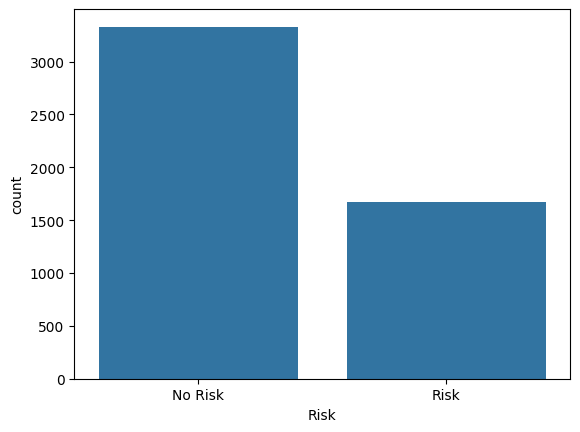

In [ ]:
import seaborn as sns
sns.countplot(x="Risk", data=german_credit)

I prefer the objects API which gice a unified API for all visualization:

In [ ]:
import seaborn.objects as so

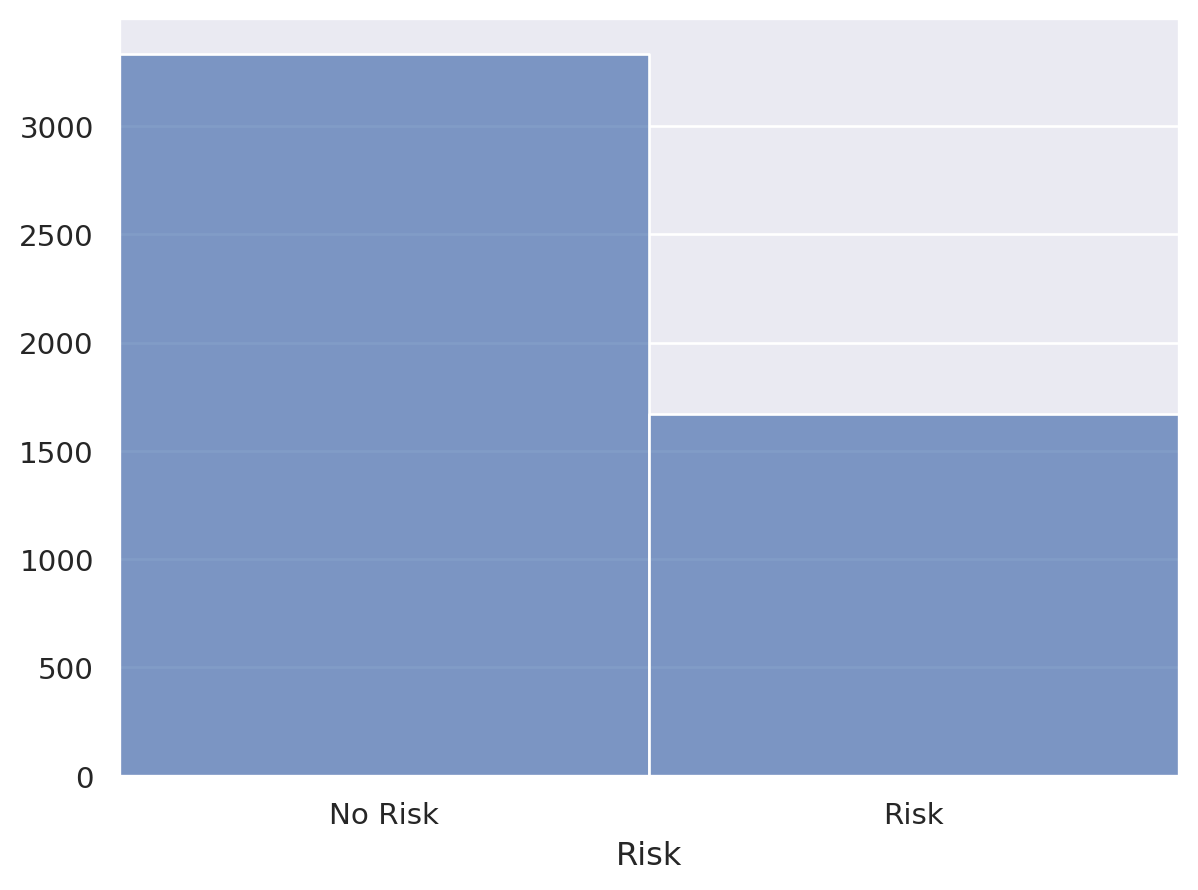

In [ ]:
(so.Plot(german_credit, x="Risk")
    .add(so.Bars(), so.Count())
)

We can observe that we have around twice more `No Risk` than `Risk` outcome. It is alway a good idea to look at the real numbers, for instance with

In [ ]:
german_credit.group_by("Risk").len().with_columns((pl.col("len") / pl.col("len").sum()).alias("perc"))

Risk,len,perc
str,u32,f64
"""Risk""",1670,0.334
"""No Risk""",3330,0.666


We have thus exactly 1/3 of `Risk` and 2/3 of `No Risk`...

**Question** Do you believe that those are the proportions in a realword use case?

**Answer** No for two reasons. First, whenever there is a too round number, there is a doubt, so that a 1/3-2/3 split is dubious. Second, default rate of 1/3 is very high, and would lead to a situation in which it is very hard for the bank to benefit from loans...

---

## Predicting the risk?

We are going to predict the risk using the accuracy as a metrics. This corresponds exactly to the $\ell^{0/1}$ loss, but the accuracy is defined as $1$ minus the expectation of the loss, so that a larger accuracy is better.

**Question** What would be the performance of a dummy classifier always predicting `No Risk`?

**Answer** A simple observation shows that such a predictor will be right $66\%$ of the time and thus have a $.66$ accuracy.

---

A natural question is now to guess whether one can do better or not. A hint that this is possible is that the `Risk` variable behaves differently depending on the covariates.

**Question** Show that this is the case with the `Sex` variable.

**Answer** A simple plot adding the `Sex` information gives a good idea that this is true:

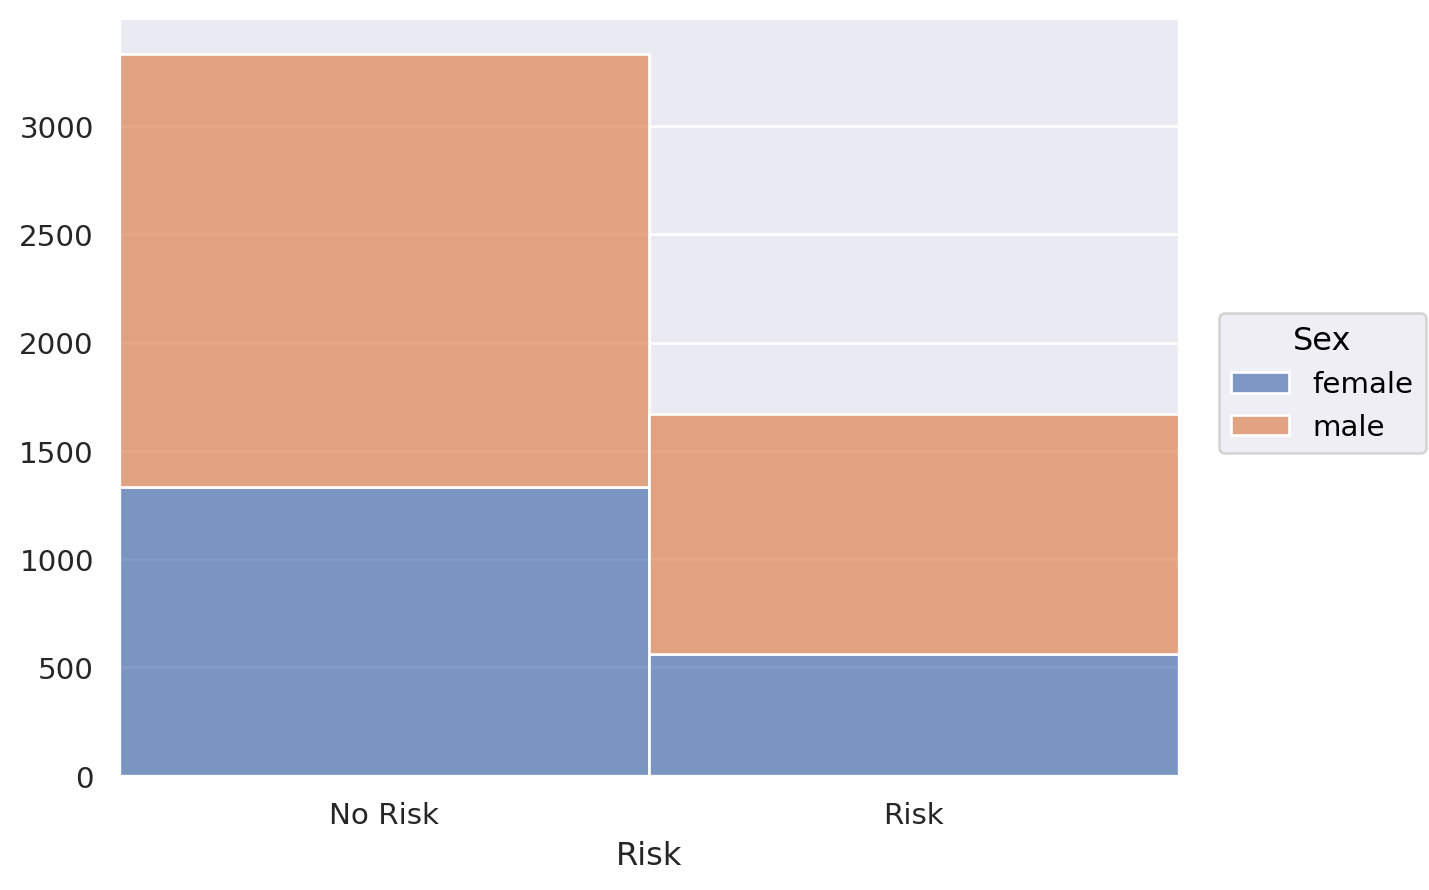

In [ ]:
(
    so.Plot(german_credit, x="Risk", color="Sex")
    .add(so.Bars(), so.Count(), so.Stack())
)

Note that this is less visible on the raw numbers:

In [ ]:
german_credit.group_by(["Risk", "Sex"]).len()

Risk,Sex,len
str,str,u32
"""Risk""","""male""",1109
"""No Risk""","""male""",1995
"""Risk""","""female""",561
"""No Risk""","""female""",1335


A better way of visualizing this is to renormalize with each `Sex` category:

In [ ]:
german_credit.group_by(["Sex", "Risk"]).len().with_columns((pl.col("len") / pl.col("len").sum()).over("Sex").alias("perc")).sort(['Sex', 'Risk'], descending=True)

Sex,Risk,len,perc
str,str,u32,f64
"""male""","""Risk""",1109,0.357281
"""male""","""No Risk""",1995,0.642719
"""female""","""Risk""",561,0.295886
"""female""","""No Risk""",1335,0.704114


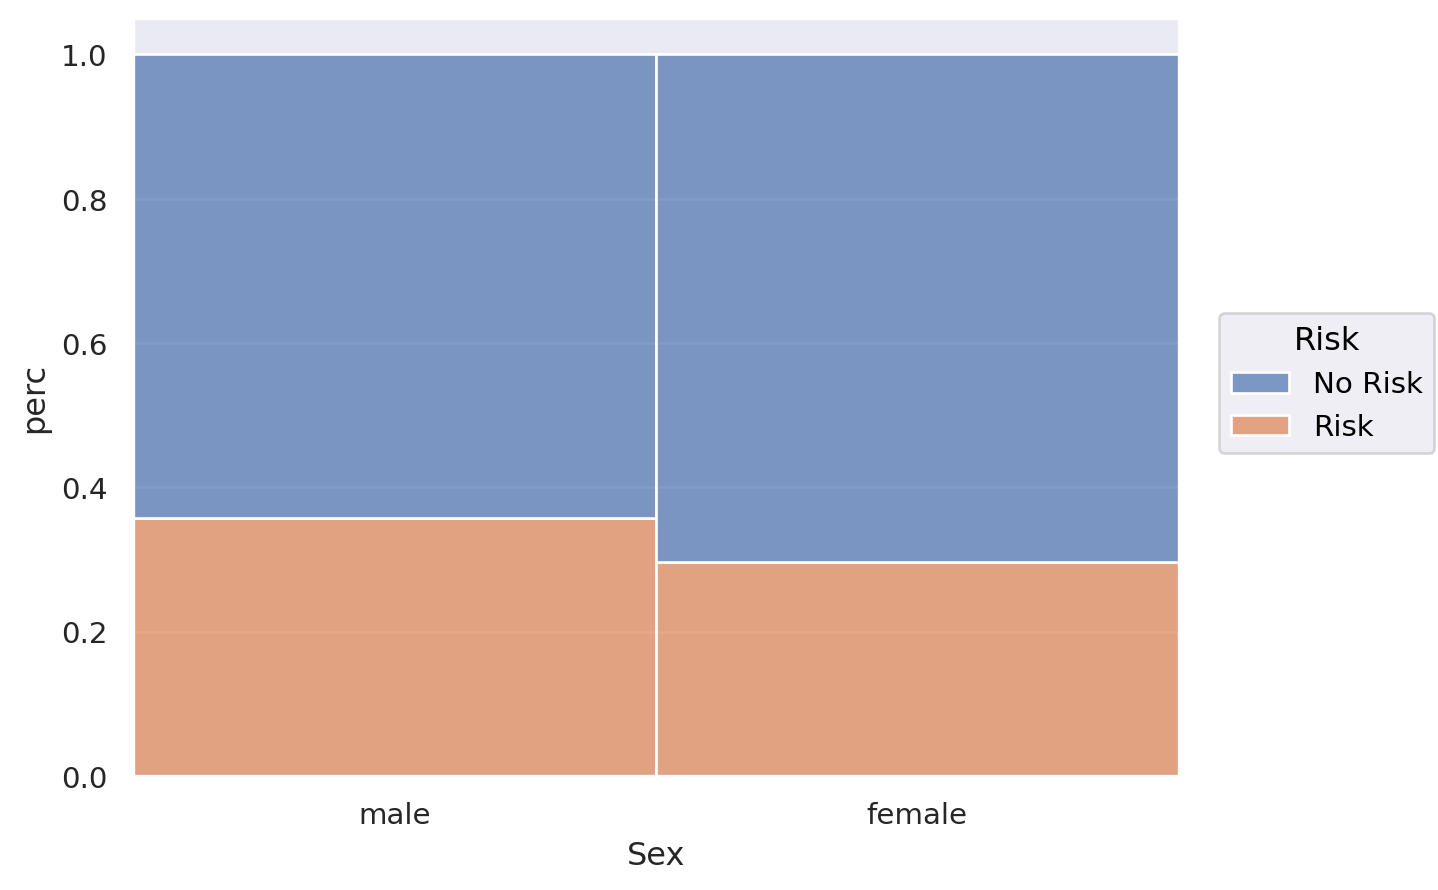

In [ ]:
tmp = german_credit.group_by(["Sex", "Risk"]).len().with_columns((pl.col("len") / pl.col("len").sum().over("Sex")).alias("perc")).sort(['Sex', 'Risk'], descending=True)
(so.Plot(tmp, x="Sex", color="Risk", y="perc")
  .add(so.Bars(), so.Stack())
  .scale(color=so.Nominal(order=["No Risk", "Risk"])))

---

## Basic ML pipeline

To make a prediction, we need to perform two steps: first, we need to transform the input into numerical vectors, and second apply a trained prediction on those numerical vectors. Note that the transformation should also be trained if it depends on variable values, for instance for a normalization.

`Scikit Learn` has a very simple way to define the prediction pipeline and train it afterward.

We need to handle in a different way the numerical variables, that are already numbers, and the categorical one, for which an encoding is required.

In [ ]:
import polars.selectors as cs
string_columns = german_credit.select(cs.string()).columns
numerical_columns = german_credit.select(cs.numeric()).columns

We are now ready to import `scikit learn`, use a one hot encoding for the categorical variables, a standardization for the numerical ones, and a nearest neighbors classifier:

In [ ]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
categorical_features = string_columns.copy()
categorical_features.remove('Risk')
categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_columns)
        ],
        remainder='passthrough',
        force_int_remainder_cols=False
    )

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', KNeighborsClassifier())]).set_output(transform="polars")

Training the pipeline is as simple as

In [ ]:
X = german_credit.drop('Risk')
y = german_credit['Risk']
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['CheckingStatus',
                                                   'CreditHistory',
                                                   'LoanPurpose',
                                                   'ExistingSavings',
                                                   'EmploymentDuration', 'Sex',
                                                   'OthersOnLoan',
                                                   'OwnsProperty',
                                                   'InstallmentPlans',
                                                   'Housing', 'Job',
                                                   'Telephone',
                                                   'ForeignWorker']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['LoanDuration', 'LoanAmount',
                                                   'InstallmentPercent',
                                                   'CurrentResidenceDuration',
                                                   'Age',
                                                   'ExistingCreditsCount',
                                                   'Dependents'])])),
                ('classifier', KNeighborsClassifier())])

and indeed, one can use the pipeline to obtain prediction

In [ ]:
pipeline.predict(X)

array(['No Risk', 'No Risk', 'No Risk', ..., 'Risk', 'Risk', 'No Risk'],
      dtype='<U7')

and compute a score

In [ ]:
pipeline.score(X, y)

0.8426

**Question** Replace the nearest neighbors by a logistic regression.

**Answer**

In [ ]:
pipeline_log = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression())]).set_output(transform="polars")

In [ ]:
pipeline_log.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['CheckingStatus',
                                                   'CreditHistory',
                                                   'LoanPurpose',
                                                   'ExistingSavings',
                                                   'EmploymentDuration', 'Sex',
                                                   'OthersOnLoan',
                                                   'OwnsProperty',
                                                   'InstallmentPlans',
                                                   'Housing', 'Job',
                                                   'Telephone',
                                                   'ForeignWorker']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['LoanDuration', 'LoanAmount',
                                                   'InstallmentPercent',
                                                   'CurrentResidenceDuration',
                                                   'Age',
                                                   'ExistingCreditsCount',
                                                   'Dependents'])])),
                ('classifier', LogisticRegression())])

In [ ]:
pipeline_log.score(X, y)

0.8042

---

## Error estimation and model comparison

**Question** Why are the previous scores optimistic?

**Answer** We have used the same data to train and test the predictor! This is much easier than predicting new values!

---

We need thus to be careful and always test predictors with data that have never been used before. `Scikit learn` has a nice way to do that.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


We can then train and test on different data(sub)set



In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['CheckingStatus',
                                                   'CreditHistory',
                                                   'LoanPurpose',
                                                   'ExistingSavings',
                                                   'EmploymentDuration', 'Sex',
                                                   'OthersOnLoan',
                                                   'OwnsProperty',
                                                   'InstallmentPlans',
                                                   'Housing', 'Job',
                                                   'Telephone',
                                                   'ForeignWorker']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['LoanDuration', 'LoanAmount',
                                                   'InstallmentPercent',
                                                   'CurrentResidenceDuration',
                                                   'Age',
                                                   'ExistingCreditsCount',
                                                   'Dependents'])])),
                ('classifier', KNeighborsClassifier())])

In [ ]:
pipeline.score(X_test, y_test)

0.766

In [ ]:
pipeline.score(X_train, y_train)

0.84275

The optimism of testing on the training set is obvious here! The estimation error term dominates the approximation error ones.

**Question** What about the logistic regression pipeline ?

**Answer**

In [ ]:
pipeline_log.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['CheckingStatus',
                                                   'CreditHistory',
                                                   'LoanPurpose',
                                                   'ExistingSavings',
                                                   'EmploymentDuration', 'Sex',
                                                   'OthersOnLoan',
                                                   'OwnsProperty',
                                                   'InstallmentPlans',
                                                   'Housing', 'Job',
                                                   'Telephone',
                                                   'ForeignWorker']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['LoanDuration', 'LoanAmount',
                                                   'InstallmentPercent',
                                                   'CurrentResidenceDuration',
                                                   'Age',
                                                   'ExistingCreditsCount',
                                                   'Dependents'])])),
                ('classifier', LogisticRegression())])

In [ ]:
pipeline_log.score(X_test, y_test)

0.793

In [ ]:
pipeline_log.score(X_train, y_train)

0.807

Less difference between the training error and the testing one, so that the approximation error probably dominates.

---

## V-fold cross validation

V-fold cross validation is a way to obtain a good error estimate using only the training set. We can use the builtin `cross_val_error` to obtain such an estimate:

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
scores

array([0.78   , 0.76375, 0.7625 , 0.76875, 0.76875])

In [ ]:
scores.mean()

0.76875

**Question** What about the logistic regression?

**Answer**

In [ ]:
scores_log = cross_val_score(pipeline_log, X_train, y_train, cv=5)
scores_log

array([0.78125, 0.80875, 0.815  , 0.80375, 0.79375])

In [ ]:
scores_log.mean()

0.8004999999999999

---

**Question** Can you reproduce those results using `KFold` ? (You may have to look at the documentation of `cross_val_score`)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

**Answer** A natural implementation is given by:

In [ ]:
res = pl.DataFrame()

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    pipeline.fit(X_train[train_index], y_train[train_index])
    res = pl.concat([res, pl.DataFrame({'score': pipeline.score(X_train[test_index], y_train[test_index])})])
res

score
f64
0.78
0.76375
0.76625
0.76625
0.77


It turns out, that we do not recover the same result than with the builtin function! Looking at the documention, we could think of a randomization issue, but by default there is no randomized shuffling, so that everything is deterministic. A closer look at the default values shows that the default scheme is not a classical k-fold but a stratified one. Indeed,

In [ ]:
from sklearn.model_selection import StratifiedKFold
strat_kf = StratifiedKFold(n_splits=5)

In [ ]:
res = pl.DataFrame()
for i, (train_index, test_index) in enumerate(strat_kf.split(X_train, y_train)):
    pipeline.fit(X_train[train_index], y_train[train_index])
    res = pl.concat([res, pl.DataFrame({'score': pipeline.score(X_train[test_index], y_train[test_index])})])
res

score
f64
0.78
0.76375
0.7625
0.76875
0.76875


---

## Learning curve

A interesting diagnostic tool is the learning curve which shows the evolution of error with respect to the number of samples.

**Question** Can you compute such a curve for the two pipelines we have used so far? What can you say about the results?

**Answer**

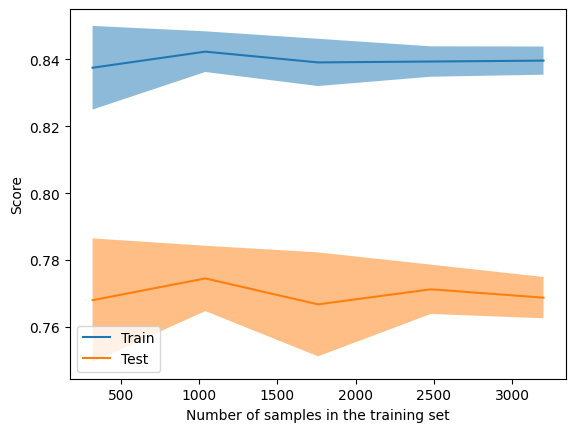

In [ ]:
from sklearn.model_selection import LearningCurveDisplay
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', KNeighborsClassifier(n_neighbors=5))]).set_output(transform="polars")
LearningCurveDisplay.from_estimator(pipeline, X_train, y_train, cv=5)

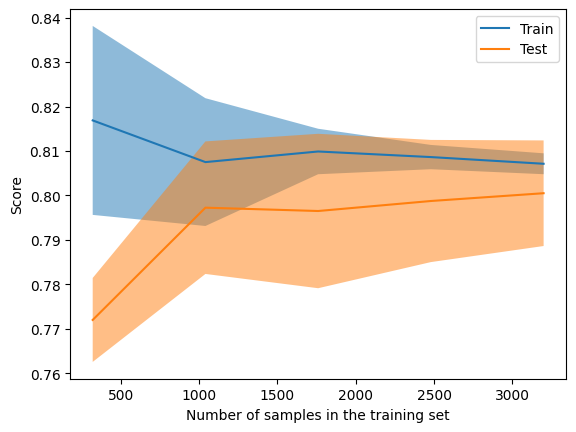

In [ ]:
from sklearn.model_selection import LearningCurveDisplay
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression())]).set_output(transform="polars")
LearningCurveDisplay.from_estimator(pipeline, X_train, y_train, cv=5)aa

It seems that the logistic regression has an expected behavior with an increase of accuracy with more data and simultaneous decrease of the optimism gap. For the nearest neighbors, we observe a non decreasing gap! It is hard to understand without noticing that the complexity of this predictor is increasing with $n$ for a fixed $k$...

As a bonus, one can recreate manually those plots with `learning_curve`, `polars` and `seaborn`

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', KNeighborsClassifier(n_neighbors=5))]).set_output(transform="polars")
train_size_abs, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=5)

In [ ]:
tmp = (pl.DataFrame({'train_size': train_size_abs, 'train': train_scores, 'test': test_scores})
 .with_columns(pl.col('train'),
               pl.col('test'))
 .explode('train', 'test')
 .unpivot(['train', 'test'], index='train_size', variable_name="train/test")
 .group_by(['train_size', 'train/test'])
 .agg(pl.col('value').mean().alias('mean'),
      pl.col('value').std().alias('std'))
 .with_columns(
      (pl.col('mean')+pl.col('std')).alias('upper'),
      (pl.col('mean')-pl.col('std')).alias('lower'))
)
tmp

train_size,train/test,mean,std,upper,lower
i64,str,f64,f64,f64,f64
2480,"""test""",0.715,0.015411,0.730411,0.699589
3200,"""train""",0.8029375,0.003199,0.806137,0.799738
1760,"""train""",0.796477,0.007585,0.804062,0.788893
320,"""train""",0.77,0.009783,0.779783,0.760217
2480,"""train""",0.801694,0.005015,0.806709,0.796678
1040,"""train""",0.794038,0.012908,0.806946,0.781131
3200,"""test""",0.7195,0.012456,0.731956,0.707044
320,"""test""",0.70175,0.008273,0.710023,0.693477
1760,"""test""",0.70775,0.013152,0.720902,0.694598


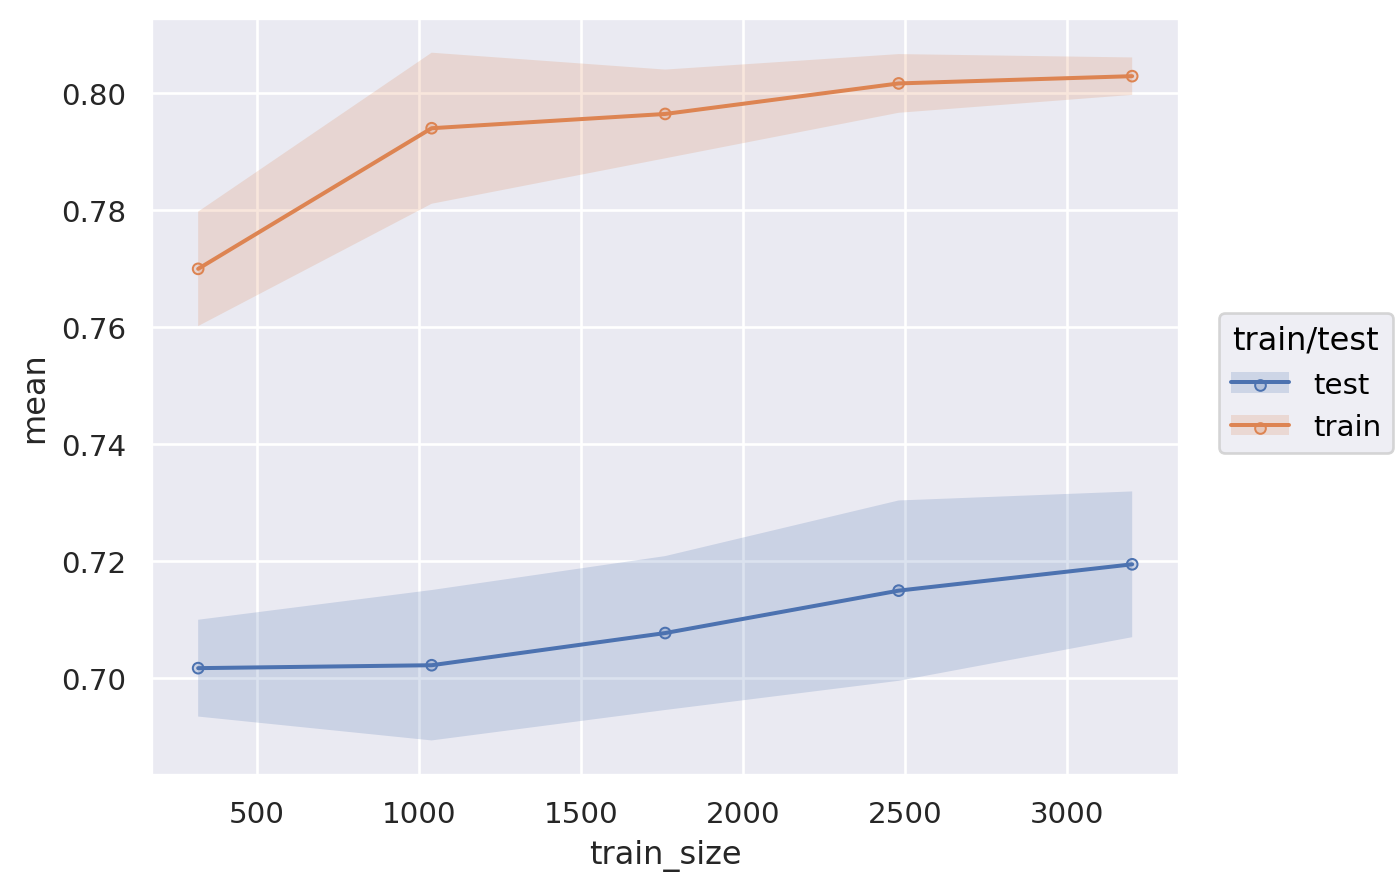

In [ ]:
so.Plot(tmp, x='train_size', y='mean', color='train/test', ymin='lower', ymax='upper')\
  .add(so.Line())\
  .add(so.Dots())\
  .add(so.Band())

---